In [37]:
#-----------------------Laboratorio 09----------------------------
# Luiz Felipe Barros Alves

In [38]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

In [39]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
emeApi = lumapi.MODE(hide = False)

Exception ignored in: <function Lumerical.__del__ at 0x000002D8FDEA8220>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\v221\api\python\lumapi.py", line 1196, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\v221\api\python\lumapi.py", line 245, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: TypeError: expected Session instance instead of Session


## Especificação dos materiais e dimensões do guia

In [40]:
# units
um = 1e-6
nm = 1e-9

In [41]:
# Materiais 
sub_material = 'SiO2 (Glass) - Palik'
core_material = 'Si (Silicon) - Palik'

In [42]:
# MMI x parameters
L = 57.42 * um
# L = 59.2*um # otimizado
W = 7.0 * um

# Taper parameters
W1 = 450 * nm
W2 = 1.5 * um
L1 = 15 * um

# Waveguide parameters
wvg_width = 450 * nm
wvg_height = 220 * nm

# Waveguide length
wvg_length = 4.0 * um

# Bandwidth operation
cband = True
filename = "S_MMI_EME_2x2_%d_um" % (L / um)

# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm


if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

nmbrFrqPnts = 20


## Criação da estrutura

In [43]:
# Definindo um grupo de estrutura
emeApi.addstructuregroup()
dev_layer = "GDS_LAYER 35:4"
emeApi.set("name", dev_layer)

In [44]:
emeApi.switchtolayout()
emeApi.deleteall()

# Adicionando um retângulo
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set("name", "box")
emeApi.set("x", 0)
emeApi.set("x span", L)
emeApi.set("y", 0)
emeApi.set("y span", W)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("material", core_material)

# Configuração dos tapers
for i in range(4):
    emeApi.addobject("linear_taper")
    emeApi.set("name", f"taper port {str(i + 1)}")
    emeApi.set("thickness", wvg_height)
    emeApi.set("angle_side", 90)
    emeApi.set("width_r", W1)
    emeApi.set("width_l", W2)
    emeApi.set("len", L1)
    emeApi.set("material", core_material)
    emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + L1/2)
    emeApi.set("y", 0)
    emeApi.set("z", wvg_height / 2)

# Ajustando as posições dos tapers
emeApi.select(f"{dev_layer}::taper port 1")
emeApi.set("width_r", W2)
emeApi.set("width_l", W1)
emeApi.set("x", -emeApi.getnamed(f"{dev_layer}::box", "x max") - L1/2)
emeApi.set("y", W/6)

emeApi.select(f"{dev_layer}::taper port 2")
emeApi.set("width_r", W2)
emeApi.set("width_l", W1)
emeApi.set("x", -emeApi.getnamed(f"{dev_layer}::box", "x max") - L1/2)
emeApi.set("y", -W/6)

emeApi.select(f"{dev_layer}::taper port 3")
emeApi.set("y", W/6)

emeApi.select(f"{dev_layer}::taper port 4")
emeApi.set("y", -W/6)

# Adicionando waveguides
for i in range(4):
    emeApi.addrect()
    emeApi.addtogroup(dev_layer)
    emeApi.set("name", f"wvguide {str(i+1)}")
    emeApi.set("x", 0)
    emeApi.set("x span", wvg_length)
    emeApi.set("y", 0)
    emeApi.set("y span", wvg_width)
    emeApi.set("z", wvg_height / 2)
    emeApi.set("z span", wvg_height)
    emeApi.set("material", core_material)

# Ajustando as posições dos wvg
emeApi.select(f"{dev_layer}::wvguide 1")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
emeApi.set("y", W/6)

emeApi.select(f"{dev_layer}::wvguide 2")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
emeApi.set("y", -W/6)

emeApi.select(f"{dev_layer}::wvguide 3")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
emeApi.set("y", W/6)

emeApi.select(f"{dev_layer}::wvguide 4")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
emeApi.set("y", -W/6)

## Adicionando solver

In [45]:
# Add solver

emeApi.switchtolayout()
emeApi.select('EME')
emeApi.delete()

bound_x_offset = 0.5 * um
bound_y_offset = 10 * um
bound_z_offset = 4 * um

emeApi.addeme()

## Dimensions
emeApi.set("x", 0)
emeApi.set("x min", emeApi.getnamed(f"{dev_layer}::wvguide 1", "x min"))

emeApi.set("y", 0)
emeApi.set("y span", W + bound_y_offset)

emeApi.set("z", wvg_height / 2)
emeApi.set("z span",  bound_z_offset)

## Background material
emeApi.set("background material", sub_material)


# Paramêtros importantes
cell_wgd = 1
cell_taper = 16
cell_box = 1

span_wgd = wvg_length 
span_taper = L1
span_box = L

method_wgd = 0  # 0 = none, 1 = CVCS
method_taper = 1
method_box = 0

modes_wgd = 4
modes_taper = 10
modes_box = 32

# Set cell properties
emeApi.set("number of cell groups", 5)
emeApi.set("group spans", np.block([[span_wgd], [span_taper], [span_box], [span_taper], [span_wgd]]))
emeApi.set("cells", np.block([[cell_wgd], [cell_taper], [cell_box], [cell_taper], [cell_wgd]]))
emeApi.set("subcell method", np.block([[method_wgd], [method_taper], [method_box], [method_taper], [method_wgd]]))
emeApi.set("allow custom eigensolver settings", True)
emeApi.set("modes", np.block([[modes_wgd], [modes_taper], [modes_box], [modes_taper], [modes_wgd]]))
emeApi.set("display cells", 1)

# Number of mesh cells without override regions
# emeApi.set("mesh cells x", 200)
emeApi.set("mesh cells y", 200)
emeApi.set("mesh cells z", 200)

# Boundary Conditions
emeApi.set("y min bc", "PML")
emeApi.set("y max bc", "PML")
emeApi.set("z min bc", "Symmetric")
emeApi.set("z max bc", "PML")


## Configura as portas
# port_y_span = 2 * um
# port_z_span = 2 * um

emeApi.select("EME::Ports::port_1")
emeApi.set("use full simulation span", 0)
emeApi.set("port location", "left")
emeApi.set("y", W/6)
emeApi.set("y span", wvg_width*1.75)
emeApi.set("z",wvg_height / 2)
emeApi.set("z span", wvg_height*1.3)
emeApi.set("mode selection","fundamental TE mode")

emeApi.select("EME::Ports::port_2")
emeApi.set("use full simulation span",0)
emeApi.set("port location", "left")
emeApi.set("y", -W/6)
emeApi.set("y span",  wvg_width*1.75)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height*1.3)
emeApi.set("mode selection","fundamental TE mode")

emeApi.addemeport()
emeApi.set("use full simulation span", 0)
emeApi.set("port location","right")
emeApi.set("y", W/6)
emeApi.set("y span", wvg_width*1.75)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height*1.3)
emeApi.set("mode selection","fundamental TE mode")

emeApi.addemeport()
emeApi.set("use full simulation span", 0)
emeApi.set("port location","right")
emeApi.set("y", -W/6)
emeApi.set("y span", wvg_width*1.75)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height*1.3)
emeApi.set("mode selection","fundamental TE mode")

In [46]:
# add monitor

emeApi.switchtolayout()
emeApi.select('profile')
emeApi.delete()
emeApi.select('mesh')
emeApi.delete()

emeApi.addemeprofile()
emeApi.set("name", "profile")
emeApi.set("monitor type", 3) #2D Z normal
emeApi.set("x", 0)
emeApi.set("x span", emeApi.getnamed("EME", "x span"))
emeApi.set("y", 0)
emeApi.set("y span",  W + bound_y_offset)
emeApi.set("z", wvg_height / 2)

# emeApi.addmesh()
# emeApi.set("x", 0)
# emeApi.set("x span", emeApi.getnamed("EME", "x span") - 2*wvg_length)
# emeApi.set("y", 0)
# emeApi.set("y span",  W*2)
# emeApi.set("z", wvg_height / 2)
# emeApi.set("z span", wvg_height*5)

# emeApi.set("set mesh multiplier", True)
# emeApi.set("x mesh multiplier", 5)
# emeApi.set("y mesh multiplier", 5)
# emeApi.set("z mesh multiplier", 5)


## Simulação

In [47]:
emeApi.save(f"C:/Users/alves/Documents/{filename}")

emeApi.run()

In [48]:
emeApi.emepropagate()

## Campo Elétrico

In [49]:
E = emeApi.getresult("profile", "field profile")

x = E['x']
x = x[:,0]/um
y = E['y']
y = y[:,0]/um
z = E['z']

E = E['E']

Ex = E[:, :, 0, :, 0]
Ey = E[:, :, 0, :, 1]
Ez = E[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

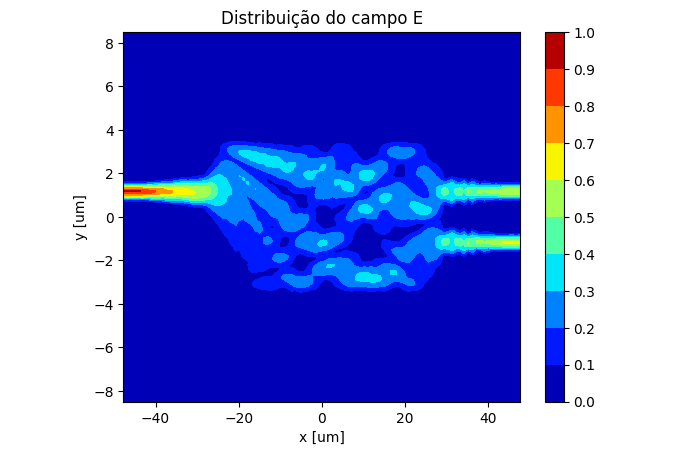

In [50]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)
plt.contourf(x, y, np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=v)

plt.title('Distribuição do campo E', fontsize=12)
plt.ylabel('y [um]', fontsize=10)
plt.xlabel('x [um]', fontsize=10)

plt.text(-75, 4, 'Port 1', fontsize=12, fontweight='bold', color='w')
plt.text(70, -4, 'Port 4', fontsize=12, fontweight='bold', color='w')
plt.text(70, 4, 'Port 3', fontsize=12, fontweight='bold', color='w')

plt.savefig('Campo_E')


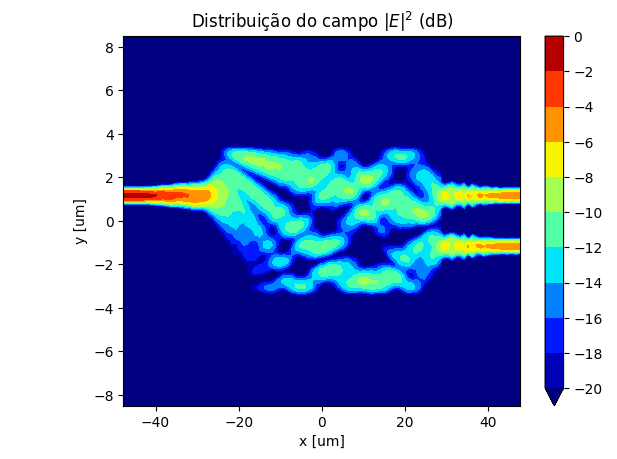

In [51]:
plt.figure()
v = np.linspace(-20, 0, 11, endpoint=True)

plt.title("Distribuição do campo $|E|^2$ (dB)", fontsize=12)
plt.ylabel("y [um]", fontsize=10)
plt.xlabel("x [um]", fontsize=10)

CS = plt.contourf(x, y, 10*np.log10(np.transpose(Emag[:,:,0])**2), v, cmap=mycmap, extend='min')
plt.colorbar(ticks=v)

plt.text(-75, 4, 'Port 1', fontsize=12, fontweight='bold', color='w')
plt.text(55, -4.5, 'Port 4', fontsize=12, fontweight='bold', color='w')
plt.text(55, 4, 'Port 3', fontsize=12, fontweight='bold', color='w')

plt.savefig('Campo_E_log')

## Wavelength Sweep

In [52]:
emeApi.setemeanalysis("group spans", np.block([[span_wgd], [span_taper], [175.5*um], [span_taper], [span_wgd]]))
emeApi.setemeanalysis('wavelength sweep', 1)
emeApi.setemeanalysis('start wavelength', wvlngth_start)
emeApi.setemeanalysis('stop wavelength', wvlngth_stop)
emeApi.setemeanalysis('number of wavelength points', nmbrFrqPnts)
emeApi.setemeanalysis('calculate group delays', 1)

In [53]:
emeApi.emesweep('wavelength sweep')
S = emeApi.getemesweep('S_wavelength_sweep')
Lambda = S['wavelength']

T1 = np.abs(S['s11'])**2
T3 = np.abs(S['s31'])**2
T4 = np.abs(S['s41'])**2

T1_dB = 10*np.log10(T1)
T3_dB = 10*np.log10(T3)
T4_dB = 10*np.log10(T4)

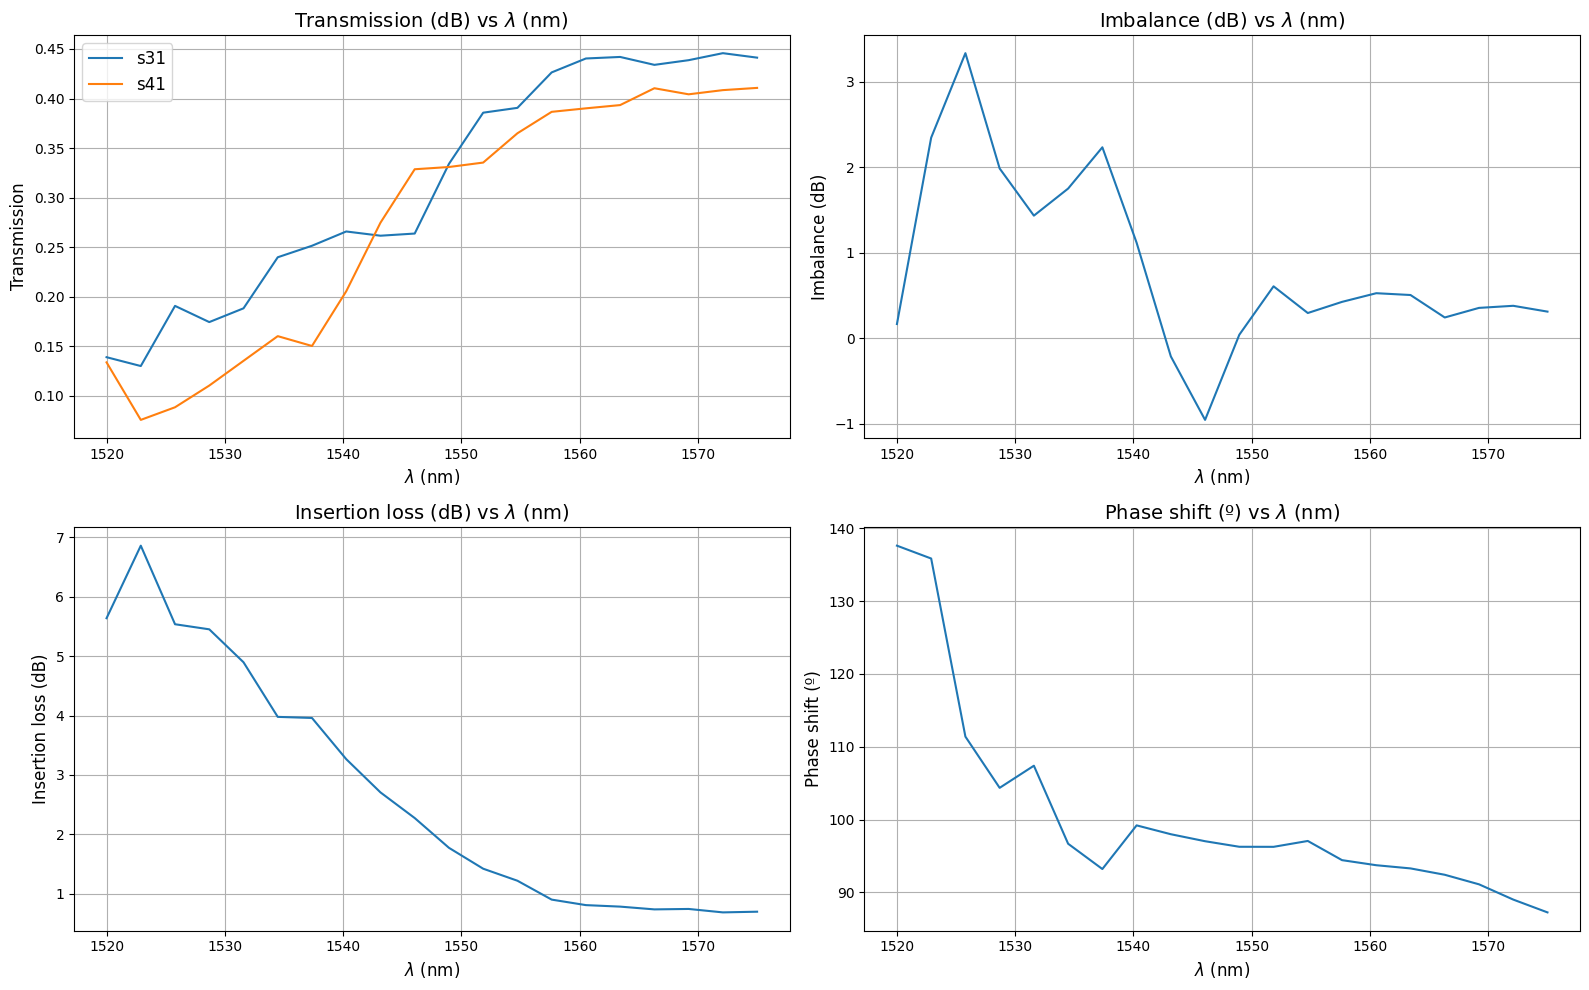

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))  

# Transmission
axs[0, 0].plot(Lambda/nm, T3, lw=1.5, label='s31')
axs[0, 0].plot(Lambda/nm, T4, lw=1.5, label='s41' )
axs[0, 0].set_xlabel(r'$\lambda$ (nm)', fontsize=12)
axs[0, 0].set_ylabel('Transmission', fontsize=12)
axs[0, 0].set_title(r'Transmission (dB) vs $\lambda$ (nm)', fontsize=14)
# axs[0, 0].set_xlim([1.53, 1.565])
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid()

# Imbalance
lb = T3_dB - T4_dB
axs[0, 1].plot(Lambda/nm, lb, lw=1.5)
axs[0, 1].set_xlabel(r'$\lambda$ (nm)', fontsize=12)
axs[0, 1].set_ylabel('Imbalance (dB)', fontsize=12)
axs[0, 1].set_title(r'Imbalance (dB) vs $\lambda$ (nm)', fontsize=14)
# axs[0, 1].set_xlim([1.53, 1.565])
axs[0, 1].grid()

# Insertion loss
li = -10 * np.log10(T3 + T4)
axs[1, 0].plot(Lambda/nm, li, lw=1.5)
axs[1, 0].set_xlabel(r'$\lambda$ (nm)', fontsize=12)
axs[1, 0].set_ylabel('Insertion loss (dB)', fontsize=12)
axs[1, 0].set_title(r'Insertion loss (dB) vs $\lambda$ (nm)', fontsize=14)
# axs[1, 0].set_xlim([1.53, 1.565])
axs[1, 0].grid()

# Phase shift
phi3 = np.angle(S['s31'])
phi4 = np.angle(S['s41'])

phaseP = (phi3 - phi4) * (180 / np.pi)

for p in range(len(phaseP)):
    if abs(phaseP[p]) > 200:
        phaseP[p] = phaseP[p] + 360

axs[1, 1].plot(Lambda/nm, phaseP, lw=1.5)
axs[1, 1].set_xlabel(r'$\lambda$ (nm)', fontsize=12)
axs[1, 1].set_ylabel('Phase shift (º)', fontsize=12)
axs[1, 1].set_title(r'Phase shift (º) vs $\lambda$ (nm)', fontsize=14)
# axs[1, 1].set_xlim([1.53, 1.565])
axs[1, 1].grid()

plt.tight_layout()
plt.savefig('wvg_sweep.png')


## Otimização do comprimento da caixa central

In [55]:
emeApi.setemeanalysis("propagation sweep", 1)
emeApi.setemeanalysis("parameter", "group span 3")
emeApi.setemeanalysis("start", 0.9 * span_box)
emeApi.setemeanalysis("stop", 1.1 * span_box)
emeApi.setemeanalysis("number of points", nmbrFrqPnts)

In [56]:
emeApi.emesweep("propagation sweep")

In [57]:
S = emeApi.getemesweep("S")
group_span = S["group_span_3"]

T1 = np.abs(S['s11'])**2
T3 = np.abs(S['s31'])**2
T4 = np.abs(S['s41'])**2

T1_dB = 10*np.log10(T1)
T3_dB = 10*np.log10(T3)
T4_dB = 10*np.log10(T4)

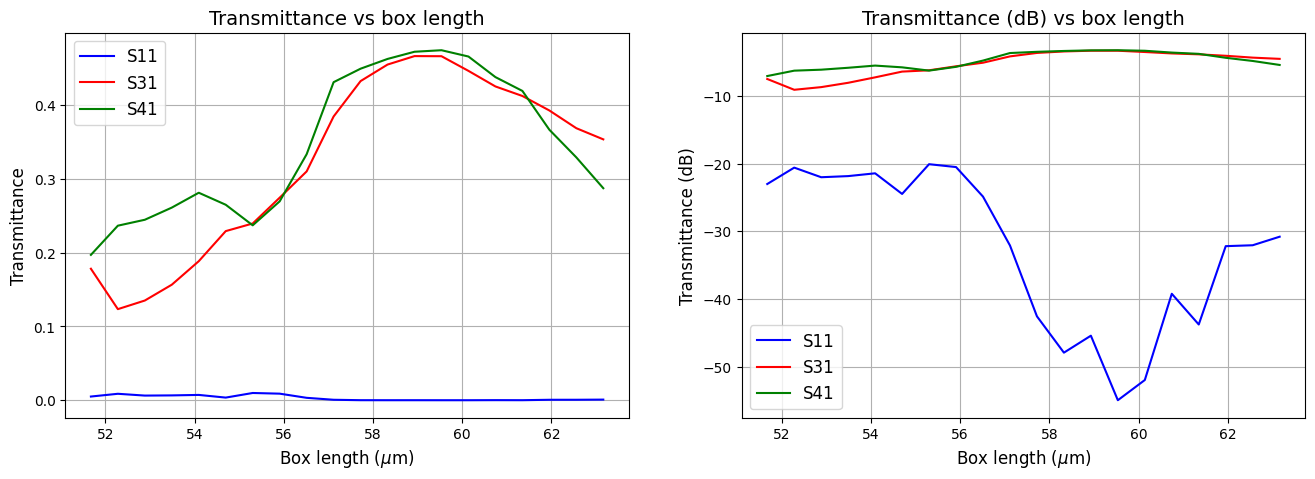

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(group_span / um, T1, 'b-', lw=1.5, label="S11")
axs[0].plot(group_span / um, T3, 'r-', lw=1.5, label="S31")
axs[0].plot(group_span / um, T4, 'g-', lw=1.5, label="S41")
axs[0].set_title("Transmittance vs box length", fontsize=14)
axs[0].set_xlabel(r"Box length ($\mu$m)", fontsize=12)
axs[0].set_ylabel("Transmittance", fontsize=12)
# axs[0].set_xlim(0.8, 0.5)
axs[0].grid()
axs[0].legend(fontsize=12)

axs[1].plot(group_span / um, T1_dB, 'b-', lw=1.5, label="S11")
axs[1].plot(group_span / um, T3_dB, 'r-', lw=1.5, label="S31")
axs[1].plot(group_span / um, T4_dB, 'g-', lw=1.5, label="S41")
axs[1].set_title("Transmittance (dB) vs box length", fontsize=14)
axs[1].set_xlabel(r"Box length ($\mu$m)", fontsize=12)
axs[1].set_ylabel("Transmittance (dB)", fontsize=12)
# axs[1].set_xlim(0.8, 0.5)
axs[1].grid()
axs[1].legend(fontsize=12)

plt.savefig('Otimizacao')

C:\Users\alves\AppData\Local\Temp\ipykernel_13436\2524828395.py:17: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width="30%", height="30%", loc="center right", bbox_transform=axs.transAxes)


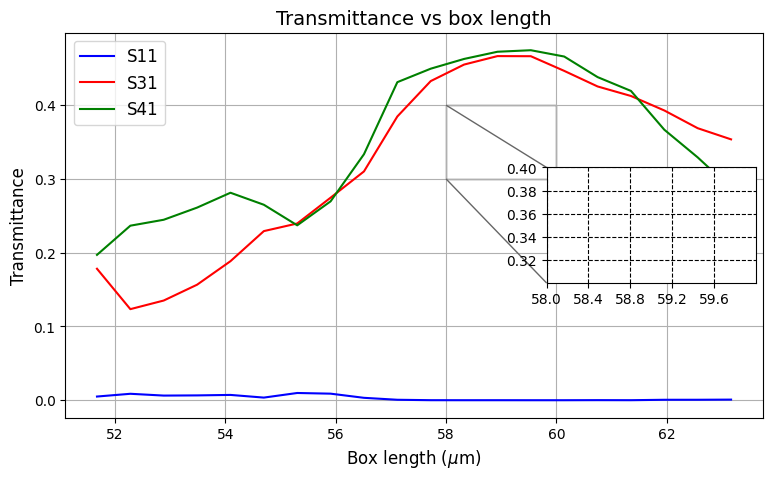

In [59]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axs = plt.subplots(figsize=(9, 5))

axs.plot(group_span / um, T1, 'b-', lw=1.5, label="S11")
axs.plot(group_span / um, T3, 'r-', lw=1.5, label="S31")
axs.plot(group_span / um, T4, 'g-', lw=1.5, label="S41")
axs.set_title("Transmittance vs box length", fontsize=14)
axs.set_xlabel(r"Box length ($\mu$m)", fontsize=12)
axs.set_ylabel("Transmittance", fontsize=12)
# axs[0].set_xlim(0.8, 0.5)
axs.grid()
axs.legend(fontsize=12)

# axins = inset_axes(axs, width="15%", height="30%", loc="upper right", bbox_to_anchor=(0.25, -0.59, 0.6, 0.95), bbox_transform=axs.transAxes)

axins = inset_axes(axs, width="30%", height="30%", loc="center right", bbox_transform=axs.transAxes)


axins.plot(group_span / um, T3, 'r-', lw=1.5, label="S31")
axins.plot(group_span / um, T4, 'g-', lw=1.5, label="S41")
axins.set_xlim(58, 60)  
axins.set_ylim(0.30, 0.40)  
axins.grid(True, color='black', linestyle='--')  
axins.set_yticks(np.arange(0.32, 0.4, step=0.02))
axins.set_xticks(np.arange(58, 60, step=0.4)) 

mark_inset(axs, axins, loc1=2, loc2=3, fc="none", ec="0.4")

plt.savefig('zoom')

plt.show()